<a href="https://colab.research.google.com/github/andersonmoura87/macroeconomia/blob/main/An%C3%A1lise_PIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workshop "Como Prever o PIB do Brasil com IA e Python?"**
---

O Produto Interno Bruto (PIB) é a soma de todos os bens e serviços finais produzidos por um país, estado ou cidade, em um determinado período no tempo.

É um indicador que ajuda a compreender a dinâmica de crescimento da economia como um todo, constituindo uma variável macroeconômica relevante para o governo, para a política monetária e para a população de forma geral.


Pela complexidade de cômputo e pela sensibilidade a crises e choques adversos, é razoável pensar que produzir previsões para o PIB é uma tarefa difícil e não muito glamourosa para profissionais que trabalham com previsão.


Pensando nisso, decidimos organizar um Workshop sobre Como Prever o PIB do Brasil utilizando os novos recursos da Inteligência Artificial. Em três horas, faremos uma exposição mão na massa e direta ao ponto, utilizando Python, para que o aluno consiga entender diversos nuances do difícil trabalho de gerar previsões acuradas para uma variável econômica tão importante quanto o PIB do país.


# **Parte 01: Bibliotecas**
---
Aqui vamos importar bibliotecas de Python que ajudam com funções úteis e prontas para coletar, tratar e analisar dados.

In [2]:
# Instalar bibliotecas
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.6 MB/s eta 0:00:00


In [3]:
# Importar bibliotecas
import pandas as pd
import pmdarima as pmd
import google.generativeai as genai
from google.colab import userdata
from io import StringIO

# **Parte 02: Coleta de Dados**
---

Aqui vamos escrever um código que acessa uma fonte de dados e baixa uma tabela automaticamente.


In [4]:
# Importar os dados
dados = pd.read_csv(
    filepath_or_buffer = "https://drive.google.com/uc?export=download&id=1ctQEVOsrjWWc-7_Us6GPacFC6bQe8G79"
    ).assign(date = lambda x: pd.PeriodIndex(x.date, freq = "Q")).set_index("date")
dados

,PIB
date,
1996Q1,2.5
1996Q2,2.1
1996Q3,2.3
1996Q4,2.2
1997Q1,3.2
...,...
2023Q1,3.7
2023Q2,3.7
2023Q3,3.1


# **Parte 03: Modelagem e Previsão**
---

Aqui vamos escrever um código para estimar um modelo automatizado de econometria e um modelo de inteligência artificial e gerar previsão para um período de teste.

In [5]:
# Separa parte dos dados para teste de previsão
h = 4
dados_teste = dados.tail(h)
dados_treino = dados.iloc[0:-h]

## Modelo de econometria

In [6]:
# Estimar o modelo automatizado ARIMA
modelo_arima = pmd.auto_arima(y = dados_treino.PIB, m = h)
modelo_arima

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 4),
      suppress_warnings=True)

In [8]:
# Produzir previsão
previsao_arima = modelo_arima.predict(h).rename("ARIMA").to_frame()
previsao_arima

,ARIMA
2023Q2,3.547208
2023Q3,2.949304
2023Q4,2.589961
2024Q1,2.026677


## Modelo de inteligência artificial

In [9]:
# Salva dados como um arquivo CSV
dados_treino.to_csv("historical_pib.csv")

In [11]:
# Configura chave de token (acesse https://ai.google.dev/gemini-api/docs/api-key
# para obter uma chave)
genai.configure(api_key = userdata.get("GEMINI_API_KEY"))

In [12]:
# Envia arquivo CSV para API do Google
arquivo = genai.upload_file("historical_pib.csv")

In [13]:
# Define prompt
data_previsao = (dados_treino.index.max() + 1).strftime("%B 30, %Y")
periodo_previsao = dados_teste.index[[0, h - 1]].strftime("%YQ%q").to_list()

prompt = f"""
Assume that you are in {data_previsao}.
Please give me your best forecast of Gross Domestic Product (GDP) for Brazil,
measured in annual percentage variation (accumulated rate in four quarters in
relation to the same period of the previous year) and published by IBGE, for
{periodo_previsao[0]} to {periodo_previsao[1]}.
Use the historical GDP data from the attached CSV file named "historical_pib.csv",
where "pib" is the target column and "date" is the date column.
Please give me numeric values for these forecasts, in a CSV like format, and
nothing more.
Do not use any information that was not available to you as of {data_previsao}
to formulate these forecasts.
"""
print(prompt)


Assume that you are in June 30, 2023.
Please give me your best forecast of Gross Domestic Product (GDP) for Brazil,
measured in annual percentage variation (accumulated rate in four quarters in
relation to the same period of the previous year) and published by IBGE, for
2023Q2 to 2024Q1.
Use the historical GDP data from the attached CSV file named "historical_pib.csv",
where "pib" is the target column and "date" is the date column.
Please give me numeric values for these forecasts, in a CSV like format, and
nothing more.
Do not use any information that was not available to you as of June 30, 2023
to formulate these forecasts.



In [14]:
# Define modelo LLM e envia prompt
modelo_ia = genai.GenerativeModel(model_name = "gemini-1.0-pro", generation_config = {"temperature": 0.1})
resposta_ia = modelo_ia.generate_content([prompt, arquivo])

# Imprime resposta do modelo
print(resposta_ia.text)

2023Q2,3.5
2023Q3,3.3
2023Q4,3.1
2024Q1,3.0


In [15]:
# Converte texto para tabela
previsao_ia = pd.read_csv(
    filepath_or_buffer = StringIO(resposta_ia.text),
    names = ["date", "Gemini"],
    #skiprows = 1
    ).assign(date = lambda x: pd.PeriodIndex(x.date, freq = "Q")).set_index("date")
previsao_ia

,Gemini
date,
2023Q2,3.5
2023Q3,3.3
2023Q4,3.1
2024Q1,3.0


In [20]:
# Junta dados observados e de previsão
tabela_previsao = (
    dados
    .tail(h*10)
    .join(other = [previsao_arima, previsao_ia], how = "outer")
    .assign(Ensemble = lambda x: (x.ARIMA + x.Gemini) / 2)
)
tabela_previsao.tail(h)

,PIB,ARIMA,Gemini,Ensemble
2023Q2,3.7,3.547208,3.5,3.523604
2023Q3,3.1,2.949304,3.3,3.124652
2023Q4,2.9,2.589961,3.1,2.844981
2024Q1,2.5,2.026677,3.0,2.513338


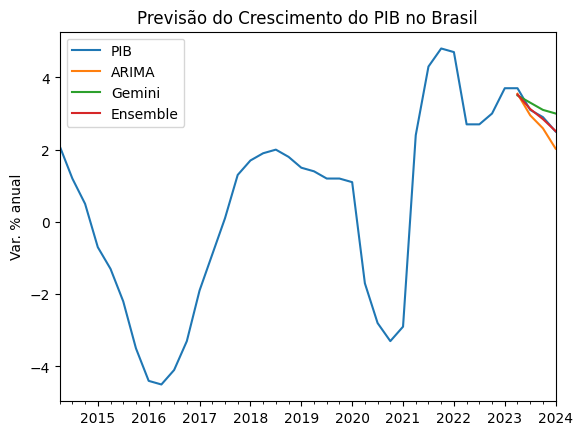

In [17]:
# Avalia erro visualmente
tabela_previsao.plot(
    title = "Previsão do Crescimento do PIB no Brasil",
    xlabel = "",
    ylabel = "Var. % anual"
    );

In [18]:
# Avalia erro numéricamente
erros_previsao = (
    tabela_previsao
    .dropna()
    .assign(
        erro_arima = lambda x: x.PIB - x.ARIMA,
        erro_gemini = lambda x: x.PIB - x.Gemini,
        erro_ensemble = lambda x: x.PIB - x.Ensemble
    )
)
erros_previsao

,PIB,ARIMA,Gemini,Ensemble,erro_arima,erro_gemini,erro_ensemble
2023Q2,3.7,3.547208,3.5,3.523604,0.152792,0.2,0.176396
2023Q3,3.1,2.949304,3.3,3.124652,0.150696,-0.2,-0.024652
2023Q4,2.9,2.589961,3.1,2.844981,0.310039,-0.2,0.055019
2024Q1,2.5,2.026677,3.0,2.513338,0.473323,-0.5,-0.013338


In [19]:
# Calcula métricas de erro
print(f"Erro médio do ARIMA é: {erros_previsao.erro_arima.mean().round(3)}")
print(f"Erro médio do Gemini é: {erros_previsao.erro_gemini.mean().round(3)}")
print(f"Erro médio do Ensemble é: {erros_previsao.erro_ensemble.mean().round(3)}")

Erro médio do ARIMA é: 0.272
Erro médio do Gemini é: -0.175
Erro médio do Ensemble é: 0.048
